In [51]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sympy as sp
from scipy.optimize import fsolve
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import weibull_min
from scipy.special import gamma
from scipy.stats import gamma as gamma_d
from scipy.stats import lognorm
from scipy.stats import rayleigh
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")
sns.set()

# Data

In [23]:
raw_data = pd.read_excel('E:\GitHub/WS_Jan.xlsx')
raw_data['date'] = pd.to_datetime(raw_data['date'], format='%d.%m.%Y %H:%M:%S')
raw_data.set_index('date', inplace = True)
raw_data = raw_data.resample('30T').asfreq()
raw_data

,spd,wd
date,,
2006-01-01 00:00:00,4.1,220.0
2006-01-01 00:30:00,8.7,220.0
2006-01-01 01:00:00,8.2,220.0
2006-01-01 01:30:00,5.7,240.0
2006-01-01 02:00:00,10.3,260.0
...,...,...
2006-01-31 21:30:00,6.2,350.0
2006-01-31 22:00:00,6.7,340.0
2006-01-31 22:30:00,5.1,340.0


# Time series

In [24]:
df = raw_data.copy()

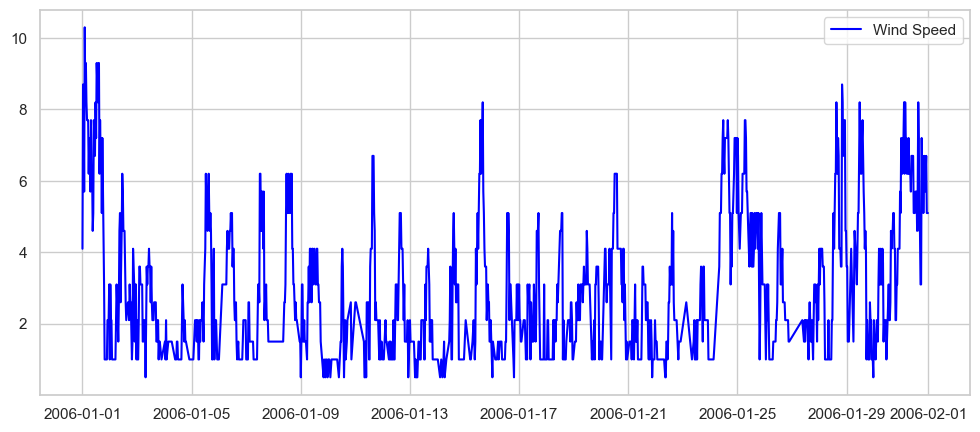

In [26]:
plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")
plt.plot(df['spd'], label='Wind Speed', color='blue')
plt.legend()
plt.grid(True)
plt.show()

# Descriptive stats

In [29]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
spd,1488.0,2.746069,1.849891,0.5,1.416667,2.100000,3.6,10.3
wd,1488.0,185.840726,99.761898,10.0,81.875000,209.782609,250.0,360.0


In [30]:
import statistics
from scipy.stats import skew, kurtosis

def descriptive_stats(data):

    # Center measures
    mean = statistics.mean(data)
    median = statistics.median(data)
    mode = statistics.mode(data)

    # Spread measures
    stdev = statistics.stdev(data)
    variance = statistics.variance(data)
    range_val = max(data) - min(data)

    # Position measures
    mini = min(data) 
    q1 = statistics.quantiles(data, n=4)[0]
    q3 = statistics.quantiles(data, n=4)[-1]
    iqr = q3 - q1
    maxi = max(data)

    # Shape measures
    skewness = skew(data)
    kurtosis_val = kurtosis(data)

    # Position measures
    mild_l = q1 - 1.5* iqr
    mild_u = q3 + 1.5* iqr

    extreme_l = q1 - 3* iqr
    extreme_u = q3 + 3* iqr
    
    stats = {'n': len(data), 'mean': round(mean, 2), 'median': round(median, 2), 'mode': mode,
             'stdev': round(stdev, 2),
             'iqr': round(iqr, 2), 'min': round(mini, 2), 'q1': round(q1, 2), 'q3': round(q3, 2),
             'max': round(maxi, 2), 'skewness': round(skewness, 2), 'kurtosis': round(kurtosis_val, 2),
             'mild_l': round(mild_l, 2), 'mild_u': round(mild_u, 2),
             'extreme_l': round(extreme_l, 2), 'extreme_u': round(extreme_u, 2)
            }

    return pd.DataFrame(stats, index=[0])

In [31]:
descriptive_stats(df.spd)

,n,mean,median,mode,stdev,iqr,min,q1,q3,max,skewness,kurtosis,mild_l,mild_u,extreme_l,extreme_u
0,1488,2.75,2.1,1.0,1.85,2.18,0.5,1.42,3.6,10.3,1.21,0.84,-1.86,6.88,-5.13,10.15


In [ ]:
# The mean in january is higher than the median indicating positive skewness
# Skewness is 1.21 > 1 and excess kurtosis > 0 indicating heavy right-tail
# Meaning outliers are strongly present in the right-tail of the distribution, as illustrated in the boxplot
# In these circumstances the median and IQR are better measures for average and variability

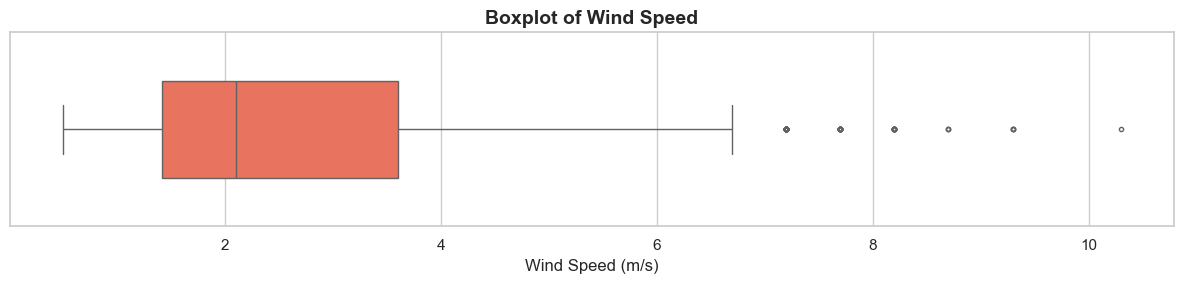

In [33]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 3))
sns.boxplot(x=df['spd'], color="tomato", width=0.5, fliersize=3)
plt.title("Boxplot of Wind Speed", fontsize=14, fontweight="bold")
plt.xlabel("Wind Speed (m/s)", fontsize=12)
plt.yticks([]) 
plt.tight_layout()
plt.show()

# Seasonality

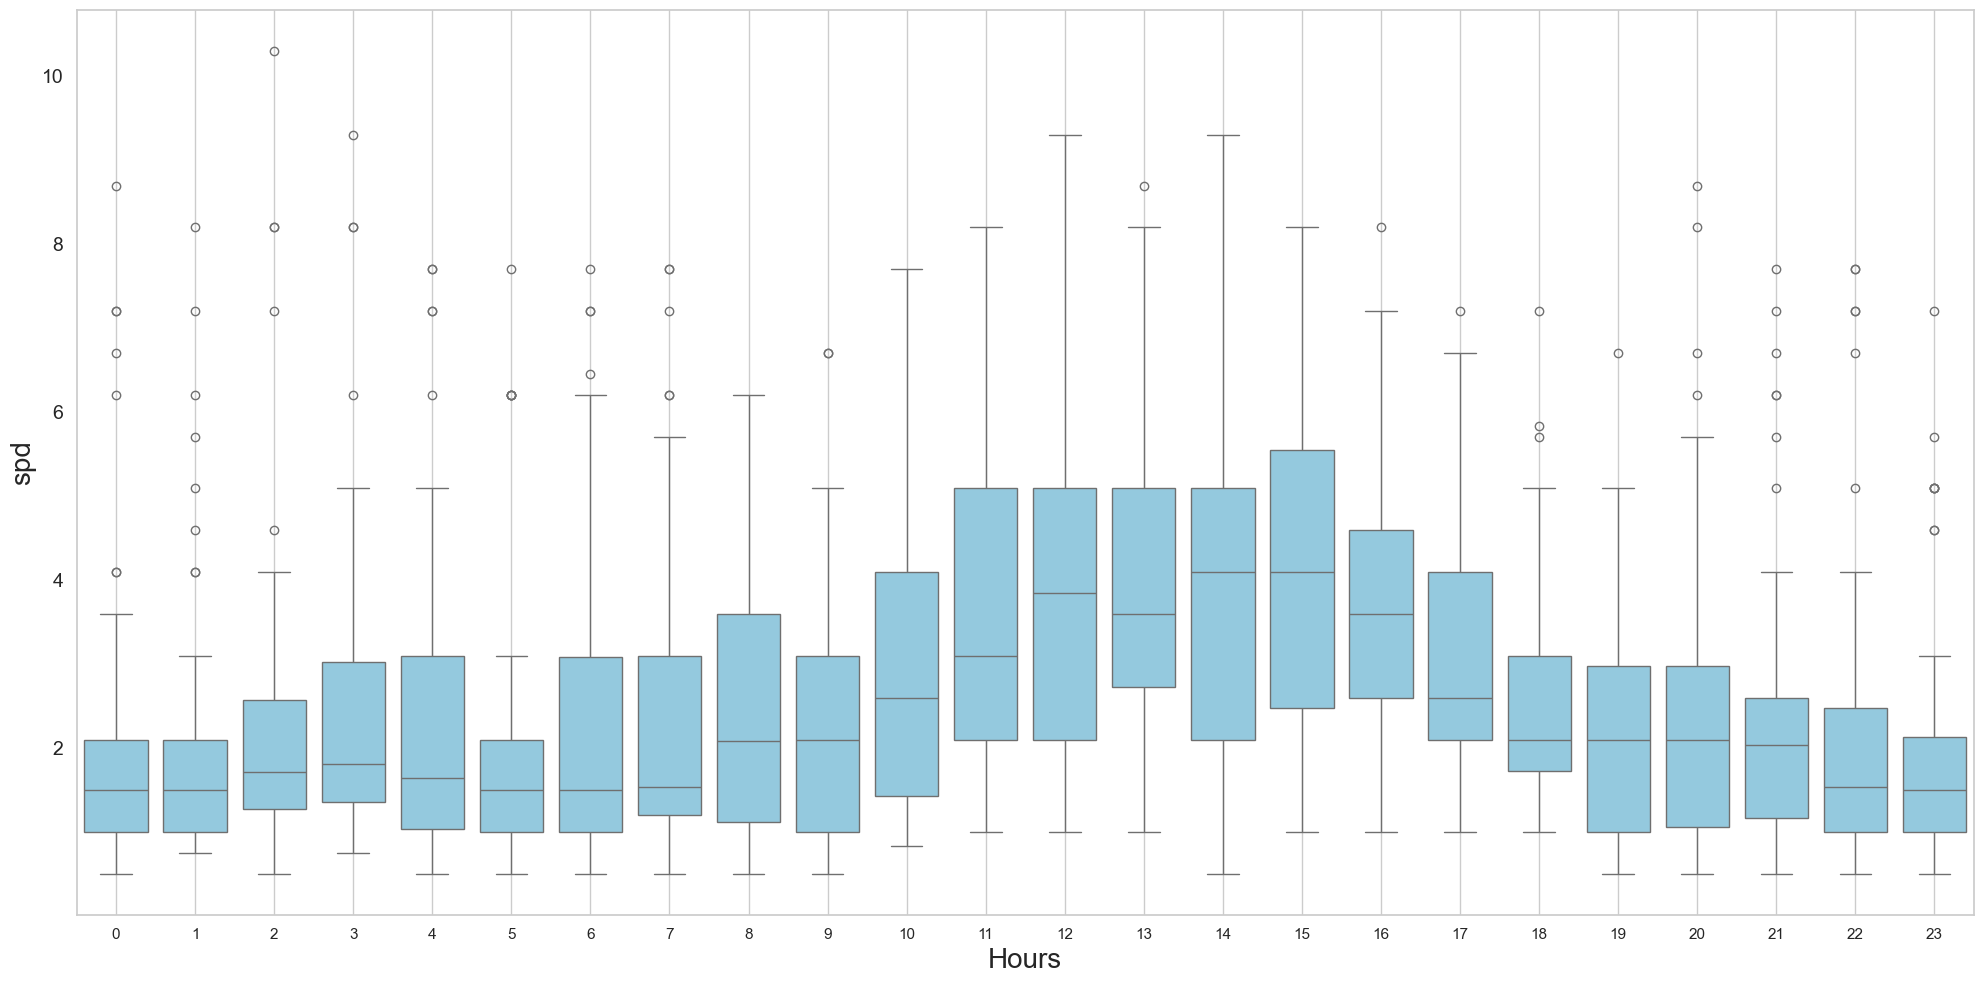

In [34]:
# Create the boxplot
plt.figure(figsize=(20, 10))
sns.boxplot(x=df.index.hour, y='spd', data=df, color='skyblue')
plt.grid(True)
# Add labels and title
plt.xlabel('Hours', size=20)
plt.ylabel('spd', size=20)
plt.yticks(size=14)
# Show grid
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# This indicates that the wind speed at this location gets stronger during the day, specifically between
# 10 AM and 6 PM in January.

# Probabilistic Modeling

In [ ]:
# Wind speed data will be modeled using the Weibull, Gamma, Rayleigh, and Lognormal distributions.
# The parameters of these PDFs will be estimated by the Maximum Likelihood Method (MLM).

## Weibull PDF

In [42]:
def max_likelihood_weibull(data):
    """
    Computes the maximum likelihood estimates of the Weibull distribution parameters 
    (shape and scale) for wind speed data. 
    If the minimum value is zero, it is replaced by 0.0001 to avoid numerical issues.
    
    Parameters:
    data (array-like): Wind speed data

    Initial Guess:
    The inverse of the coef of variation and the mean are used as initial guesses for the shape and scale parameters.
    
    Returns:
    tuple: (shape, scale) parameters of the Weibull distribution
    """
    # Replace minimum value with 0.0001 if there are zeros
    if min(data) == 0:
        data = np.where(data == 0, 0.0001, data)
    
    # Define the negative log-likelihood function
    def neg_log_likelihood_weib(params):
        shape, scale = params
        if shape <= 0 or scale <= 0:
            return np.inf  # Avoid invalid parameters
        return -np.sum(weibull_min.logpdf(data, c=shape, loc=0, scale=scale))

    # Initial guess for shape and scale parameters
    initial_guess = [np.mean(data) / np.std(data), np.mean(data)]
    
    # Optimize using Maximum Likelihood Estimation
    result_mle = minimize(neg_log_likelihood_weib, initial_guess, method='L-BFGS-B')
    
    return tuple(result_mle.x)  # Returns (shape, scale)

In [43]:
max_likelihood_weibull(df['spd'])

(1.6042823549408547, 3.0883005531775396)

In [67]:
w2_shape, w2_scale = max_likelihood_weibull(df['spd'])
w2_shape, w2_scale

(1.6042823549408547, 3.0883005531775396)

## Gamma PDF

In [45]:
def max_likelihood_gamma(data):
    """
    Computes the maximum likelihood estimates of the Gamma distribution parameters 
    (shape and scale) for wind speed data. If the minimum value is zero, it is replaced 
    by 0.0001 to avoid numerical issues.
    
    Parameters:
    data (array-like): Wind speed data
    
    Returns:
    tuple: (shape, scale) parameters of the Gamma distribution
    """
    # Replace minimum value with 0.0001 if there are zeros
    data = np.where(data == 0, 0.0001, data)
    
    # Define the negative log-likelihood function
    def neg_log_likelihood_gamma(params):
        shape, scale = params
        if shape <= 0 or scale <= 0:
            return np.inf  # Avoid invalid parameters
        return -np.sum(gamma_d.logpdf(data, a=shape, loc=0, scale=scale))

    # Initial guess for shape and scale parameters
    initial_guess = [np.mean(data) / np.std(data), np.mean(data)]
    
    # Optimize using Maximum Likelihood Estimation
    result_mle = minimize(neg_log_likelihood_gamma, initial_guess, method='L-BFGS-B')
    
    return tuple(result_mle.x)  # Returns (shape, scale)

In [47]:
g_shape, g_scale = max_likelihood_gamma(df['spd'])
g_shape, g_scale

(2.520257135037192, 1.0895985430377197)

## Lognormal PDF

In [48]:
def max_likelihood_lognormal(data):
    """
    Computes the maximum likelihood estimates of the Lognormal distribution parameters 
    (shape, scale) for wind speed data. If the minimum value is zero, it is replaced 
    by 0.0001 to avoid numerical issues.
    
    Parameters:
    data (array-like): Wind speed data
    
    Returns:
    DataFrame: A DataFrame containing the estimated shape and scale parameters.
    """
    # Replace minimum value with 0.0001 if there are zeros
    data = np.where(data == 0, 0.0001, data)
    
    # Define the negative log-likelihood function
    def neg_log_likelihood_lognormal(params):
        shape, scale = params
        if shape <= 0 or scale <= 0:
            return np.inf  # Avoid invalid parameters
        return -np.sum(lognorm.logpdf(data, s=shape, loc=0, scale=scale))

    # Initial guess for shape and scale parameters
    initial_guess = [np.std(np.log(data)), np.exp(np.mean(np.log(data)))]
    
    # Optimize using Maximum Likelihood Estimation
    result_mle = minimize(neg_log_likelihood_lognormal, initial_guess, method='L-BFGS-B')
    
    # Create a DataFrame for the output
    return tuple(result_mle.x)  # Returns (shape, location)

In [52]:
l_shape, l_scale = max_likelihood_lognormal(df['spd'])
l_shape, l_scale

(0.6519065093232431, 2.2229854050939726)

## Rayleigh PDF

In [53]:
def max_likelihood_rayleigh(data):
    # Replace minimum value with 0.0001 if there are zeros
    data = np.where(data == 0, 0.0001, data)
    
    # Define the negative log-likelihood function
    def neg_log_likelihood_rayleigh(params):
        scale = params
        if scale <= 0:
            return np.inf  # Avoid invalid parameters pareto.pdf(x, b=shape, loc=0, scale=scale)
        return -np.sum(rayleigh.logpdf(data,  loc=0, scale=scale))

    # Initial guess for shape and scale parameters
    initial_guess = [np.exp(np.mean(np.log(data)))]
    
    # Optimize using Maximum Likelihood Estimation
    result_mle = minimize(neg_log_likelihood_rayleigh, initial_guess, method='L-BFGS-B')
    
    # Create a DataFrame for the output
    return tuple(result_mle.x)  # Returns (shape, location)

In [55]:
r_scale = max_likelihood_rayleigh(df['spd'])
r_scale

(2.341013565620359,)

# Histogram

In [58]:
data = df['spd']

In [59]:
# Define the bin edges for the histogram
bin_edges = np.arange(0, int(data.max()) + 2, 1)
bin_edges

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [60]:
# Calculate the histogram
hist_counts, _ = np.histogram(data, bins=bin_edges, density=True)

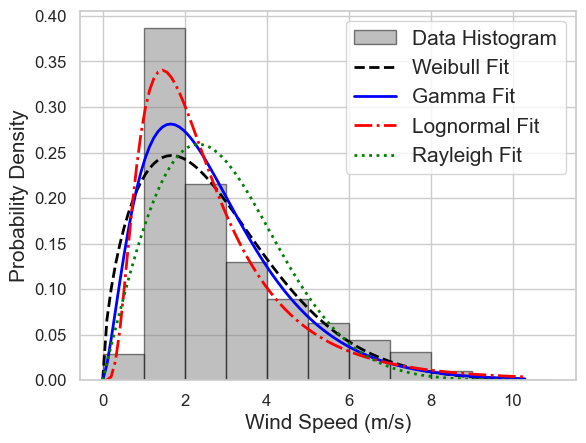

In [80]:
# Plot histogram
fig, ax = plt.subplots()
sns.set_theme(style="whitegrid")
ax.hist(data, bins=bin_edges, density=True, alpha=0.5, label="Data Histogram", color="gray", edgecolor="black")

# Generate x-values for Weibull PDF
x = np.linspace(0, data.max(), 100)
weibull_pdf = weibull_min.pdf(x, c=w2_shape, loc=0, scale=w2_scale)
gamma_pdf = gamma_d.pdf(x, a = g_shape, loc=0, scale= g_scale)
lognorm_pdf = lognorm.pdf(x, s = l_shape, loc=0, scale= l_scale)
rayleigh_pdf = rayleigh.pdf(x,  loc=0, scale= r_scale)

# Plot PDF
ax.plot(x, weibull_pdf, 'r-', lw=2, label="Weibull Fit", color = 'black', linestyle = '--')
ax.plot(x, gamma_pdf, 'r-', lw=2, label="Gamma Fit", color = 'blue')
ax.plot(x, lognorm_pdf, 'r-', lw=2, label="Lognormal Fit", color = 'red', linestyle = '-.')
ax.plot(x, rayleigh_pdf, 'r-', lw=2, label="Rayleigh Fit", color = 'green', linestyle = ':')

# Formatting
ax.legend(fontsize=15)
ax.set_xlabel("Wind Speed (m/s)", fontsize=15)
ax.set_ylabel("Probability Density", fontsize=15)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Show the plot
plt.show()

# Goodness of fit

In [98]:
import numpy as np
import pandas as pd
from scipy.stats import ks_1samp, weibull_min, gamma as gamma_d, lognorm, rayleigh
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Functions
def log_likelihood(data, dist, params):
    return np.sum(dist.logpdf(data, *params))

def aic_bic(loglik, k, n):
    aic = 2 * k - 2 * loglik
    bic = k * np.log(n) - 2 * loglik
    return aic, bic

def gof_metrics(actual_probs, estimated_probs):
    actual_probs = np.asarray(actual_probs)
    estimated_probs = np.asarray(estimated_probs)
    
    rmse = np.sqrt(mean_squared_error(actual_probs, estimated_probs))
    mae = mean_absolute_error(actual_probs, estimated_probs)
    r2 = r2_score(actual_probs, estimated_probs)
    
    return rmse, mae, r2

# Placeholder for results
results = []

# Distributions and their configurations
distributions = {
    "Weibull": {
        "dist": weibull_min,
        "params": (w2_shape, 0, w2_scale),
        "num_params": 2
    },
    "Gamma": {
        "dist": gamma_d,
        "params": (g_shape, 0, g_scale),
        "num_params": 2
    },
    "Lognormal": {
        "dist": lognorm,
        "params": (l_shape, 0, l_scale),
        "num_params": 2
    },
    "Rayleigh": {
        "dist": rayleigh,
        "params": (0, r_scale),
        "num_params": 1
    }
}

# Normalize histogram
hist_probs = hist_counts / np.sum(hist_counts)

# Loop through distributions
for name, config in distributions.items():
    dist = config["dist"]
    params = config["params"]
    k = config["num_params"]

    # PDF-based bin probabilities
    probs = np.zeros(len(bin_edges) - 1)
    for i in range(len(bin_edges) - 1):
        probs[i] = dist.cdf(bin_edges[i + 1], *params) - dist.cdf(bin_edges[i], *params)

    # Goodness-of-fit metrics
    rmse, mae, r2 = gof_metrics(hist_probs, probs)

    # Log-likelihood on raw data
    loglik = log_likelihood(data, dist, params)
    aic, bic = aic_bic(loglik, k, len(data))

    # Kolmogorov–Smirnov test
    ks_stat, ks_p = ks_1samp(data, cdf=lambda x: dist.cdf(x, *params))

    # Store result
    results.append({
        "Distribution": name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
        "AIC": aic,
        "BIC": bic,
        "KS_stat": ks_stat,
        "KS_p": ks_p
    })

In [99]:
# Create DataFrame
gof_df = pd.DataFrame(results)
gof_df

,Distribution,RMSE,MAE,R²,AIC,BIC,KS_stat,KS_p
0,Weibull,0.058850,0.033145,0.722181,5520.355936,5530.966313,0.136645,1.074646e-24
1,Gamma,0.047691,0.029723,0.817552,5423.554261,5434.164638,0.129155,4.232719e-22
2,Lognormal,0.033473,0.022958,0.910124,5330.848003,5341.458379,0.099467,2.875570e-13
3,Rayleigh,0.061653,0.039839,0.695091,5663.294915,5668.600103,0.221840,8.417638e-65
